In [1]:
import numpy as np
import pandas as pd

import osmnx as ox
import networkx as nx

import math
import requests
import mapbox_vector_tile

import matplotlib.pyplot as plt
from IPython.display import IFrame

ox.config(log_console=True, use_cache=True)
ox.__version__

%matplotlib inline

In [8]:
def pathFinder(A, B):
    
    
    route_df = pd.DataFrame()
    
    location_point = A
    G = ox.graph_from_point(location_point, distance=2000, clean_periphery=False)
    
    origin = A
    destination = B 
    
    origin_node = ox.get_nearest_node(G, origin)
    destination_node = ox.get_nearest_node(G, destination)
    
    #single path using dijkstra algorithm
    #route = nx.shortest_path(G, origin_node, destination_node, method='dijkstra')

    # all possible shortest path
    routes = [p for p in nx.all_shortest_paths(G, origin_node, destination_node)]
    for idx, route in enumerate(routes):
    
       # Show map and routes
    
        print("Route {}".format(idx+1))
        fig, ax = ox.plot_graph_route(G, route)
    
        nodes, edges = ox.graph_to_gdfs(G)
        routes_stepwise = nodes[nodes.index.isin(route)][["y", "x"]] # latitude, longitude
        routes_stepwise["route"] = idx + 1
        route_df = route_df.append(routes_stepwise)
        
    return route_df

In [9]:
def tileCalculater(latitude, longitude ,tileSize = 512, zoom = 15):
        
    sinLatitude = np.sin(latitude * np.pi/180)
    
    pixelX = ((longitude + 180) / 360) * tileSize * np.power(2, zoom)
    pixelY = (0.5 - np.log((1 + sinLatitude) / (1 - sinLatitude)) / (4 * np.pi)) * tileSize * np.power(2, zoom)
    
    mapWidth = tileSize * np.power(2, zoom)
    mapHeight = mapWidth

    numberOfTilesWide = np.power(2, zoom)
    numberOfTilesHigh = numberOfTilesWide

    tileX = math.floor(pixelX / tileSize)
    tileY = math.floor(pixelY / tileSize)
    
    return tileX, tileY

In [10]:
def extractJsonValues(obj, key):
    
    """Pull all values of specified key from nested JSON."""
    
    arr = []

    def extract(obj, arr, key):
        """Recursively search for values of key in JSON tree."""
        if isinstance(obj, dict):
            for k, v in obj.items():
                if isinstance(v, (dict, list)):
                    extract(v, arr, key)
                elif k == key:
                    arr.append(v)
        elif isinstance(obj, list):
            for item in obj:
                extract(item, arr, key)
        return arr

    results = extract(obj, arr, key)
    return results

In [11]:
def trafficFlow(tileX, tileY, tileSize = 512, zoom = 15):

    """
    API endpoint 
    """

    tileFormat = "pbf"
    style = "relative"
    key = "yf8upXHhjg4n0O5hf-i24-ZKPZN5kRbE4gGT-_3_TOU"

    URL = "https://atlas.microsoft.com/traffic/flow/tile/{0}?api-version=1.0&style={1}&tileSize={2}&zoom={3}&subscription-key={4}&x={5}&y={6}".format(tileFormat,
                                                                                                                                                  style,
                                                                                                                                                  tileSize,
                                                                                                                                                  zoom,
                                                                                                                                                  key,
                                                                                                                                                  tileX,
                                                                                                                                                  tileY) 
    out = requests.get(url=URL)
    tileLayer = mapbox_vector_tile.decode(out.content)
    
    return np.average(extractJsonValues(tileLayer["Traffic flow"], 'traffic_level'))

In [12]:
def main(A, B):

    optimalPath = pathFinder(A, B)
    suggested_paths_with_pollution = {}
    
    for name, group in optimalPath.groupby("route"):
        
        point_to_point_pollution = []
        
        for row in group.itertuples():
            tileX, tileY = tileCalculater(row.y, row.x, tileSize=512, zoom =15)
            normalizedPollution = trafficFlow(tileX, tileY)
            point_to_point_pollution.append(normalizedPollution)
            
        suggested_paths_with_pollution[name] = ((group[["x","y"]].values), np.average(point_to_point_pollution)*100)

    return suggested_paths_with_pollution

Route 1


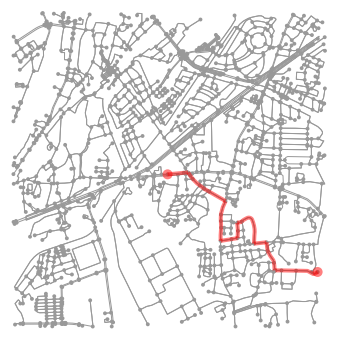

Route 2


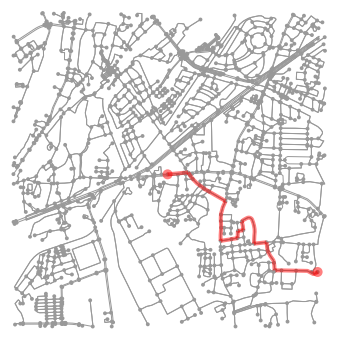

Route 3


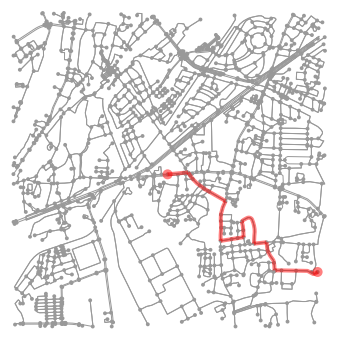

Route 4


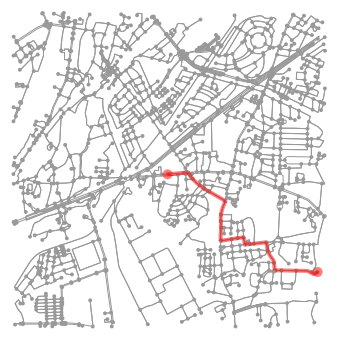

Route 5


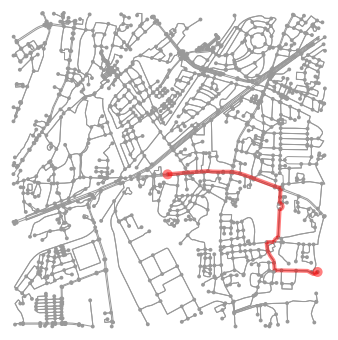

CPU times: user 10.3 s, sys: 478 ms, total: 10.8 s
Wall time: 42.5 s


{1: (array([[72.8999399, 19.0428093],
         [72.8894242, 19.0539141],
         [72.8868134, 19.0538636],
         [72.8893122, 19.0540833],
         [72.9050809, 19.0426273],
         [72.9006827, 19.0428066],
         [72.8933081, 19.0492262],
         [72.888781 , 19.0540397],
         [72.8933346, 19.047734 ],
         [72.8938663, 19.0507718],
         [72.8895808, 19.0537105],
         [72.8898799, 19.0533218],
         [72.8918813, 19.0518702],
         [72.8933005, 19.0484856],
         [72.9024595, 19.0427785],
         [72.8998441, 19.0428093],
         [72.8997716, 19.0436815],
         [72.8989886, 19.0450697],
         [72.8973339, 19.0458849],
         [72.8988581, 19.0460434],
         [72.8932703, 19.0462073],
         [72.8945837, 19.0463973],
         [72.8953286, 19.0465194],
         [72.895376 , 19.0473546],
         [72.8952933, 19.0483008],
         [72.8958528, 19.0484311],
         [72.89177  , 19.0519308],
         [72.8912936, 19.0521902],
         [72.8912

In [13]:
%%time 

A = (19.054408, 72.887029)
B = (19.043867, 72.909777)

main(A, B)

Route 1


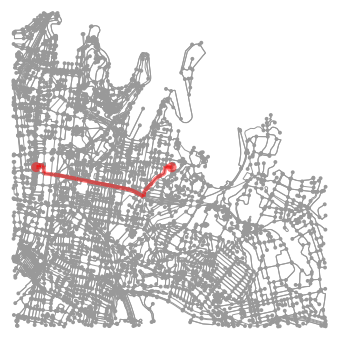

Route 2


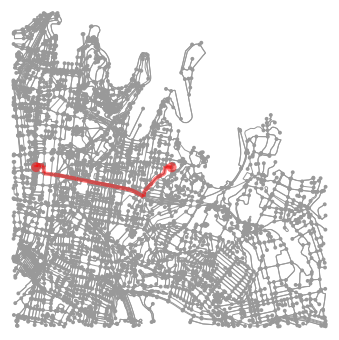

Route 3


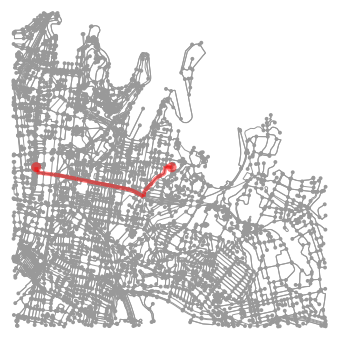

CPU times: user 17.8 s, sys: 714 ms, total: 18.5 s
Wall time: 54.2 s


{1: (array([[151.2172632, -33.8745017],
         [151.2133364, -33.8738755],
         [151.2074514, -33.8723929],
         [151.2074903, -33.8721991],
         [151.2081681, -33.8722215],
         [151.2220044, -33.8753886],
         [151.2091914, -33.8732262],
         [151.221289 , -33.8754718],
         [151.2239998, -33.8734946],
         [151.2127486, -33.8737776],
         [151.2223583, -33.8749189],
         [151.2242117, -33.873401 ],
         [151.2125886, -33.8737085],
         [151.2180583, -33.8746442],
         [151.2197107, -33.8749123],
         [151.2081346, -33.8731183],
         [151.2144165, -33.87405  ],
         [151.207111 , -33.8724057],
         [151.2229964, -33.8743471],
         [151.2099035, -33.8733015],
         [151.2113534, -33.8735295],
         [151.2100661, -33.8733122],
         [151.2163118, -33.874347 ],
         [151.224981 , -33.872305 ],
         [151.2258411, -33.8724255],
         [151.2179418, -33.8746231],
         [151.2153895, -33.8742081]

In [20]:
%%time 

A = (-33.872693, 151.225563)
B = (-33.872545, 151.207097)

main(A, B)